# Q2: ViT for classification

## data preprocess

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append((filename, img))
    return images

directories = {
    'NEUTROPHIL': '/content/drive/MyDrive/data/BCCD/NEUTROPHIL',
    'EOSINOPHIL': '/content/drive/MyDrive/data/BCCD/EOSINOPHIL',
    'MONOCYTE': '/content/drive/MyDrive/data/BCCD/MONOCYTE',
    'LYMPHOCYTE': '/content/drive/MyDrive/data/BCCD/LYMPHOCYTE'
}

data = []
for label, folder in directories.items():
    imgs = load_images_from_folder(folder)
    for img in imgs:
        data.append((label, img[0], img[1]))

df = pd.DataFrame(data, columns=['label', 'filename', 'image'])

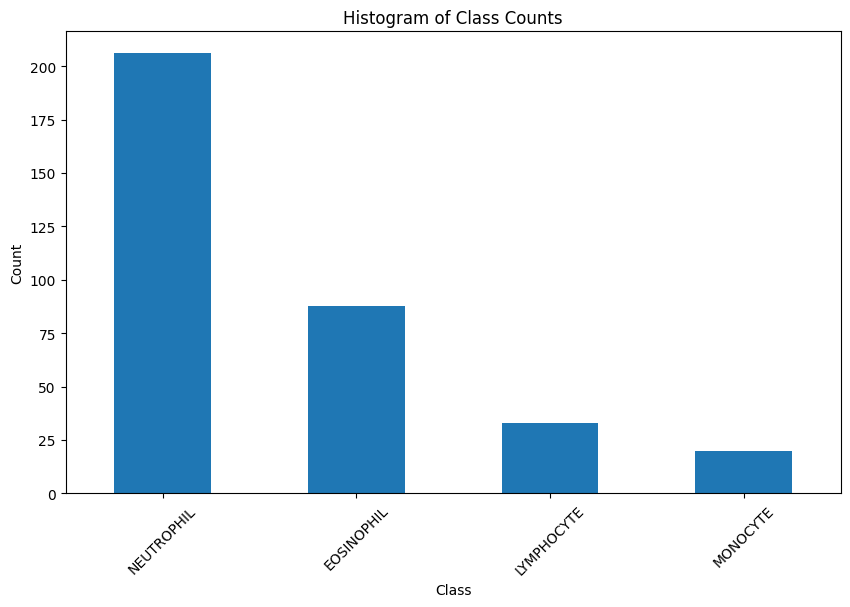

In [3]:
import matplotlib.pyplot as plt

class_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [4]:
import albumentations as A
import cv2

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
augmented_data = []

for class_name, count in class_counts.items():
    class_samples = df[df['label'] == class_name]

    while sum(1 if (x['label']==class_name) else 0 for x in augmented_data)<(250 - count):
        sample = class_samples.sample(n=1).iloc[0]
        image_path = os.path.join('/content/drive/MyDrive/data/BCCD', sample['label'],sample['filename'])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = transform(image=image)
        augmented_image = augmented['image']

        augmented_data.append({
            'label': class_name,
            'filename': f"aug_{len(augmented_data)}_{sample['filename']}.jpg",
            'image': augmented_image,
        })


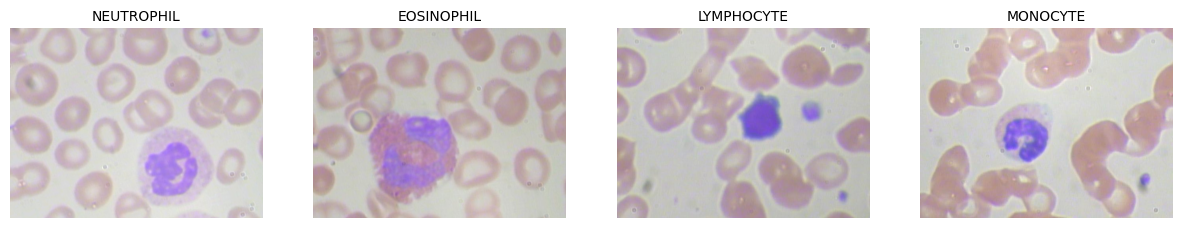

In [6]:
display_images = []
loaded_labels = []
for item in augmented_data:
    if item['label'] not in loaded_labels:
        display_images.append(item['image'])
        loaded_labels.append(item['label'])

fig, axs = plt.subplots(1, len(display_images), figsize=(15, 5))
for i, (image, label) in enumerate(zip(display_images, loaded_labels)):
    axs[i].imshow(image)
    axs[i].set_title(label, fontsize=10)
    axs[i].axis('off')
plt.show()

In [7]:
augmented_df = pd.DataFrame(augmented_data)
augmented_df = pd.concat([df, augmented_df], ignore_index=True)

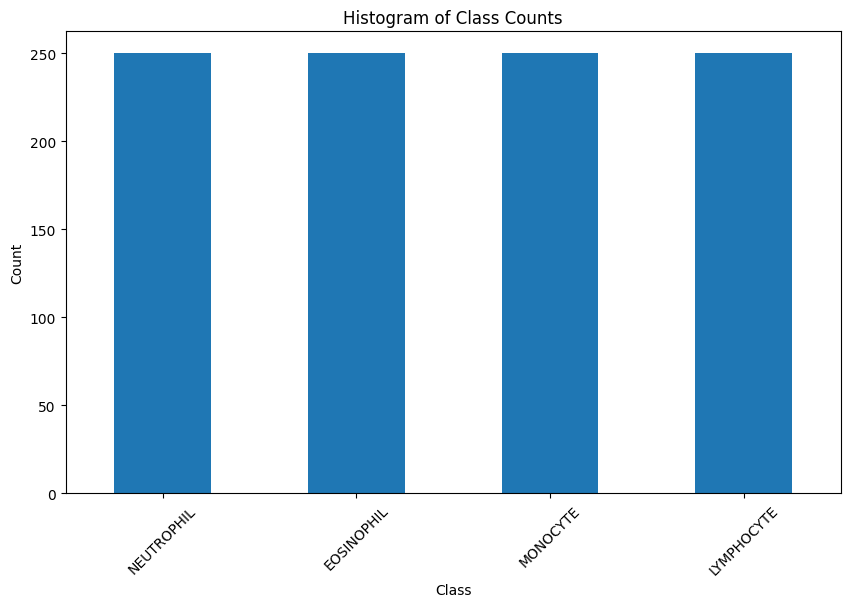

In [8]:
class_counts = augmented_df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
class WBCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']

        if self.transform:
            img = self.transform(img)

        return img, label

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(augmented_df, test_size=0.1, random_state=42, stratify=augmented_df['label'])

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

train_dataset = WBCDataset(train_df, transform=transform)
test_dataset = WBCDataset(test_df, transform=transform)

In [12]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ViT Model

In [28]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
model.to(device)
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [41]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [42]:
label_mapping = {label: idx for idx, label in enumerate(augmented_df['label'].unique())}

In [43]:
from sklearn.metrics import classification_report

print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.00      0.00      0.00        25
  EOSINOPHIL       0.00      0.00      0.00        25
    MONOCYTE       0.50      0.36      0.42        25
  LYMPHOCYTE       0.25      0.80      0.38        25

    accuracy                           0.29       100
   macro avg       0.19      0.29      0.20       100
weighted avg       0.19      0.29      0.20       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Training Classifier

In [44]:
classifier_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
classifier_ft_model.to(device)

for name, param in classifier_ft_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in classifier_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight is trainable.
classifier.bias is trainable.


In [49]:
total_params = sum(p.numel() for p in classifier_ft_model.parameters())

trainable_params = sum(p.numel() for p in classifier_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 3076


In [45]:
from torch.optim import Adam

optimizer = Adam([{'params': classifier_ft_model.classifier.parameters(), 'lr': 1e-4},], lr=1e-4)

classifier_ft_model.train()

num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = classifier_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]))

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_predictions += (outputs.logits.argmax(dim=1) == torch.tensor([label_mapping[i] for i in labels]).to(device)).sum().item()
        total_predictions += torch.tensor([label_mapping[i] for i in labels]).size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = correct_predictions / total_predictions

    losses.append(average_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy}")

Epoch 1, Loss: 1.3392023642857869, Accuracy: 0.36666666666666664
Epoch 2, Loss: 1.167828967696742, Accuracy: 0.6266666666666667
Epoch 3, Loss: 1.0546243358076663, Accuracy: 0.6866666666666666
Epoch 4, Loss: 0.9712912858578197, Accuracy: 0.7044444444444444
Epoch 5, Loss: 0.9078013029014855, Accuracy: 0.7166666666666667
Epoch 6, Loss: 0.8578137933162221, Accuracy: 0.7311111111111112
Epoch 7, Loss: 0.8172498491772434, Accuracy: 0.74
Epoch 8, Loss: 0.7834457493664926, Accuracy: 0.7422222222222222
Epoch 9, Loss: 0.754624841506021, Accuracy: 0.7511111111111111
Epoch 10, Loss: 0.7295743885793184, Accuracy: 0.7588888888888888


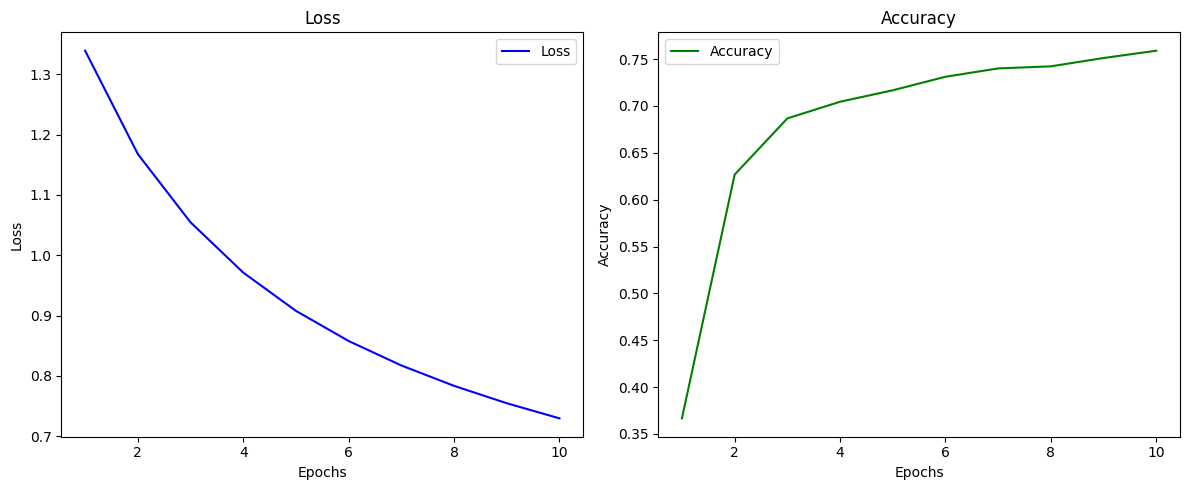

In [46]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = classifier_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [48]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.77      0.80      0.78        25
  EOSINOPHIL       0.74      0.56      0.64        25
    MONOCYTE       0.71      0.80      0.75        25
  LYMPHOCYTE       0.81      0.88      0.85        25

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



### first 2 layers

In [30]:
first2_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
first2_ft_model.to(device)

for name, param in first2_ft_model.named_parameters():
    if ("vit.encoder.layer.0." not in name) and ("vit.encoder.layer.1." not in name) and ("classifier" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in first2_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.encoder.layer.0.attention.attention.query.weight is trainable.
vit.encoder.layer.0.attention.attention.query.bias is trainable.
vit.encoder.layer.0.attention.attention.key.weight is trainable.
vit.encoder.layer.0.attention.attention.key.bias is trainable.
vit.encoder.layer.0.attention.attention.value.weight is trainable.
vit.encoder.layer.0.attention.attention.value.bias is trainable.
vit.encoder.layer.0.attention.output.dense.weight is trainable.
vit.encoder.layer.0.attention.output.dense.bias is trainable.
vit.encoder.layer.0.intermediate.dense.weight is trainable.
vit.encoder.layer.0.intermediate.dense.bias is trainable.
vit.encoder.layer.0.output.dense.weight is trainable.
vit.encoder.layer.0.output.dense.bias is trainable.
vit.encoder.layer.0.layernorm_before.weight is trainable.
vit.encoder.layer.0.layernorm_before.bias is trainable.
vit.encoder.layer.0.layernorm_after.weight is trainable.
vit.encoder.layer.0.layernorm_after.bias is trainable.
vit.encoder.layer.1.attention.at

In [31]:
total_params = sum(p.numel() for p in first2_ft_model.parameters())

trainable_params = sum(p.numel() for p in first2_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 14178820


In [52]:
optimizer = Adam([{'params': first2_ft_model.parameters(), 'lr': 1e-4},], lr=1e-4)

first2_ft_model.train()

num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = first2_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]).to(device))

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_predictions += (outputs.logits.argmax(dim=1) == torch.tensor([label_mapping[i] for i in labels]).to(device)).sum().item()
        total_predictions += torch.tensor([label_mapping[i] for i in labels]).size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = correct_predictions / total_predictions

    losses.append(average_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy}")

Epoch 1, Loss: 1.1692730481164497, Accuracy: 0.5577777777777778
Epoch 2, Loss: 0.6164069855422304, Accuracy: 0.8788888888888889
Epoch 3, Loss: 0.30816084643205005, Accuracy: 0.9588888888888889
Epoch 4, Loss: 0.1779485705651735, Accuracy: 0.9844444444444445
Epoch 5, Loss: 0.1289347914096556, Accuracy: 0.9888888888888889
Epoch 6, Loss: 0.10852720915225514, Accuracy: 0.9922222222222222
Epoch 7, Loss: 0.06527451308150041, Accuracy: 0.9977777777777778
Epoch 8, Loss: 0.043114073737932926, Accuracy: 1.0
Epoch 9, Loss: 0.0311024680145477, Accuracy: 1.0
Epoch 10, Loss: 0.023779623275786116, Accuracy: 1.0


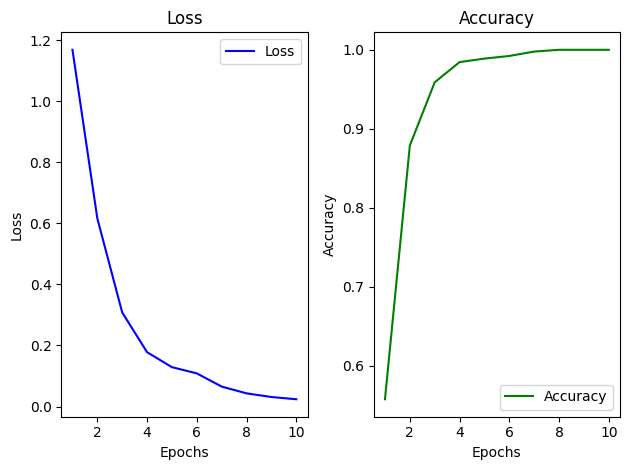

In [53]:
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = first2_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [55]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.95      0.84      0.89        25
  EOSINOPHIL       0.86      0.96      0.91        25
    MONOCYTE       1.00      0.96      0.98        25
  LYMPHOCYTE       0.96      1.00      0.98        25

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



### last 2 layers

In [32]:
last2_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
last2_ft_model.to(device)

for name, param in last2_ft_model.named_parameters():
    if ("vit.encoder.layer.10" not in name) and ("vit.encoder.layer.11" not in name) and ("classifier" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in last2_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.encoder.layer.10.attention.attention.query.weight is trainable.
vit.encoder.layer.10.attention.attention.query.bias is trainable.
vit.encoder.layer.10.attention.attention.key.weight is trainable.
vit.encoder.layer.10.attention.attention.key.bias is trainable.
vit.encoder.layer.10.attention.attention.value.weight is trainable.
vit.encoder.layer.10.attention.attention.value.bias is trainable.
vit.encoder.layer.10.attention.output.dense.weight is trainable.
vit.encoder.layer.10.attention.output.dense.bias is trainable.
vit.encoder.layer.10.intermediate.dense.weight is trainable.
vit.encoder.layer.10.intermediate.dense.bias is trainable.
vit.encoder.layer.10.output.dense.weight is trainable.
vit.encoder.layer.10.output.dense.bias is trainable.
vit.encoder.layer.10.layernorm_before.weight is trainable.
vit.encoder.layer.10.layernorm_before.bias is trainable.
vit.encoder.layer.10.layernorm_after.weight is trainable.
vit.encoder.layer.10.layernorm_after.bias is trainable.
vit.encoder.laye

In [33]:
total_params = sum(p.numel() for p in last2_ft_model.parameters())

trainable_params = sum(p.numel() for p in last2_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 14178820


In [58]:
optimizer = Adam([{'params': last2_ft_model.parameters(), 'lr': 1e-4},], lr=1e-4)

last2_ft_model.train()

num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = last2_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]))

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_predictions += (outputs.logits.argmax(dim=1) == torch.tensor([label_mapping[i] for i in labels]).to(device)).sum().item()
        total_predictions += torch.tensor([label_mapping[i] for i in labels]).size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = correct_predictions / total_predictions

    losses.append(average_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy}")

Epoch 1, Loss: 0.7439348540808025, Accuracy: 0.7033333333333334
Epoch 2, Loss: 0.2500343154789063, Accuracy: 0.9133333333333333
Epoch 3, Loss: 0.11602389472618438, Accuracy: 0.9566666666666667
Epoch 4, Loss: 0.05291445500201039, Accuracy: 0.9877777777777778
Epoch 5, Loss: 0.02241903054936413, Accuracy: 0.9966666666666667
Epoch 6, Loss: 0.01269213207425517, Accuracy: 0.9977777777777778
Epoch 7, Loss: 0.07861827982471145, Accuracy: 0.9733333333333334
Epoch 8, Loss: 0.031338776292263025, Accuracy: 0.9933333333333333
Epoch 9, Loss: 0.016984279379820486, Accuracy: 0.9955555555555555
Epoch 10, Loss: 0.02402531184366365, Accuracy: 0.9933333333333333


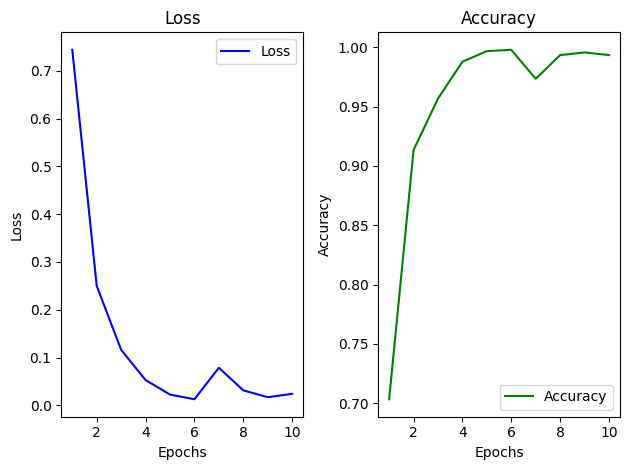

In [59]:
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = last2_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [61]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.96      0.92      0.94        25
  EOSINOPHIL       0.92      0.96      0.94        25
    MONOCYTE       1.00      1.00      1.00        25
  LYMPHOCYTE       1.00      1.00      1.00        25

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



### all layers

In [62]:
all_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
all_ft_model.to(device)

for name, param in all_ft_model.named_parameters():
    param.requires_grad = True

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
total_params = sum(p.numel() for p in all_ft_model.parameters())

trainable_params = sum(p.numel() for p in all_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 85801732


In [64]:
optimizer = Adam([{'params': all_ft_model.parameters(), 'lr': 1e-4},], lr=1e-4)

all_ft_model.train()

num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = all_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]))

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_predictions += (outputs.logits.argmax(dim=1) == torch.tensor([label_mapping[i] for i in labels]).to(device)).sum().item()
        total_predictions += torch.tensor([label_mapping[i] for i in labels]).size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = correct_predictions / total_predictions

    losses.append(average_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy}")

Epoch 1, Loss: 0.5724968268421659, Accuracy: 0.7677777777777778
Epoch 2, Loss: 0.13500077415894912, Accuracy: 0.9533333333333334
Epoch 3, Loss: 0.082865886263582, Accuracy: 0.9688888888888889
Epoch 4, Loss: 0.01174327152527934, Accuracy: 0.9955555555555555
Epoch 5, Loss: 0.028516665395153195, Accuracy: 0.99
Epoch 6, Loss: 0.10218025093975787, Accuracy: 0.9666666666666667
Epoch 7, Loss: 0.0643649603895794, Accuracy: 0.9822222222222222
Epoch 8, Loss: 0.020537236628833375, Accuracy: 0.9944444444444445
Epoch 9, Loss: 0.0022625828181238226, Accuracy: 1.0
Epoch 10, Loss: 0.0004374785016887217, Accuracy: 1.0


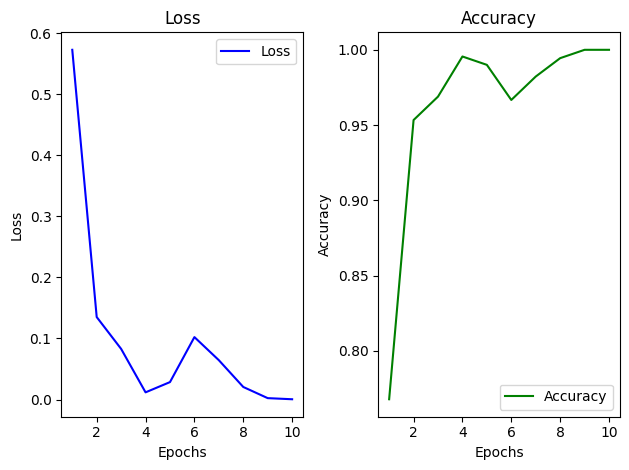

In [65]:
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = all_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [67]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.89      1.00      0.94        25
  EOSINOPHIL       1.00      0.88      0.94        25
    MONOCYTE       1.00      1.00      1.00        25
  LYMPHOCYTE       1.00      1.00      1.00        25

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



## CNN

In [68]:
import torch
import torch.nn as nn
from torchvision import models

cnn_model = models.densenet121(pretrained=True)
cnn_model.classifier = nn.Linear(cnn_model.classifier.in_features, 4)
cnn_model.to(device)
cnn_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 100MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [69]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = cnn_model(imgs.to(device))
        batch_predictions = torch.argmax(outputs, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [70]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.00      0.00      0.00        25
  EOSINOPHIL       0.12      0.04      0.06        25
    MONOCYTE       0.21      0.76      0.32        25
  LYMPHOCYTE       0.00      0.00      0.00        25

    accuracy                           0.20       100
   macro avg       0.08      0.20      0.10       100
weighted avg       0.08      0.20      0.10       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### all layers

In [35]:
all_cnn_model = models.densenet121(pretrained=True)
all_cnn_model.classifier = nn.Linear(all_cnn_model.classifier.in_features, 4)

c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
total_params = sum(p.numel() for p in all_cnn_model.parameters())

trainable_params = sum(p.numel() for p in all_cnn_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 6957956
Trainable parameters: 6957956


In [73]:
loss_fn = nn.CrossEntropyLoss()

In [75]:
optimizer = Adam([{'params': all_cnn_model.parameters(), 'lr': 1e-4},], lr=1e-4)
all_cnn_model.to(device)
all_cnn_model.train()

num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = all_cnn_model(images.to(device))
        loss = loss_fn(outputs.to(device), torch.tensor([label_mapping[i] for i in labels]).to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_predictions += (outputs.argmax(dim=1) == torch.tensor([label_mapping[i] for i in labels]).to(device)).sum().item()
        total_predictions += torch.tensor([label_mapping[i] for i in labels]).size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = correct_predictions / total_predictions

    losses.append(average_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy}")

Epoch 1, Loss: 0.8414047595701719, Accuracy: 0.6866666666666666
Epoch 2, Loss: 0.16974348725195518, Accuracy: 0.9766666666666667
Epoch 3, Loss: 0.04307421914448863, Accuracy: 1.0
Epoch 4, Loss: 0.021425434175813406, Accuracy: 1.0
Epoch 5, Loss: 0.013895004587411358, Accuracy: 1.0
Epoch 6, Loss: 0.010067531945216552, Accuracy: 1.0
Epoch 7, Loss: 0.007855937542524515, Accuracy: 1.0
Epoch 8, Loss: 0.006393784367103587, Accuracy: 1.0
Epoch 9, Loss: 0.005343756180975521, Accuracy: 1.0
Epoch 10, Loss: 0.004553347687122592, Accuracy: 1.0


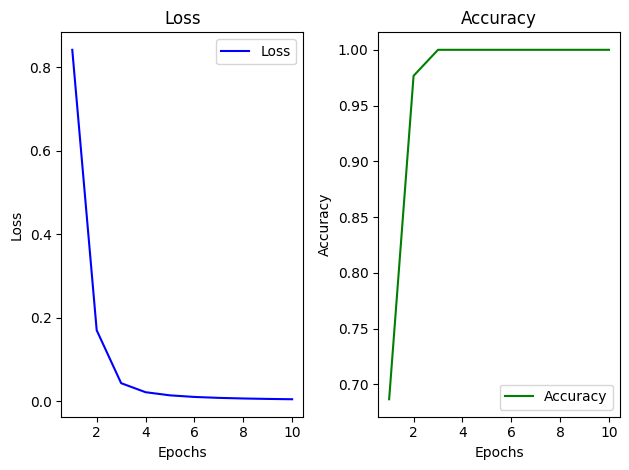

In [76]:
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = all_cnn_model(imgs.to(device))
        batch_predictions = torch.argmax(outputs, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [78]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.92      0.88      0.90        25
  EOSINOPHIL       0.85      0.88      0.86        25
    MONOCYTE       1.00      0.96      0.98        25
  LYMPHOCYTE       0.96      1.00      0.98        25

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



### classifier

In [79]:
classifier_cnn_model = models.densenet121(pretrained=True)
classifier_cnn_model.classifier = nn.Linear(classifier_cnn_model.classifier.in_features, 4)
_=classifier_cnn_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [80]:
for name, param in classifier_cnn_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in classifier_cnn_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

classifier.weight is trainable.
classifier.bias is trainable.


In [81]:
total_params = sum(p.numel() for p in classifier_cnn_model.parameters())

trainable_params = sum(p.numel() for p in classifier_cnn_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 6957956
Trainable parameters: 4100


In [82]:
optimizer = Adam([{'params': classifier_cnn_model.classifier.parameters(), 'lr': 1e-4},], lr=1e-4)

classifier_cnn_model.train()

num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = classifier_cnn_model(images.to(device))
        loss = loss_fn(outputs.to(device), torch.tensor([label_mapping[i] for i in labels]).to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_predictions += (outputs.argmax(dim=1) == torch.tensor([label_mapping[i] for i in labels]).to(device)).sum().item()
        total_predictions += torch.tensor([label_mapping[i] for i in labels]).size(0)

    average_loss = total_loss / len(train_data_loader)
    accuracy = correct_predictions / total_predictions

    losses.append(average_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Loss: {average_loss}, Accuracy: {accuracy}")

Epoch 1, Loss: 1.3982861648526108, Accuracy: 0.26
Epoch 2, Loss: 1.3604350424649423, Accuracy: 0.3277777777777778
Epoch 3, Loss: 1.3273190510900397, Accuracy: 0.37666666666666665
Epoch 4, Loss: 1.2965572445016158, Accuracy: 0.4266666666666667
Epoch 5, Loss: 1.26778164871952, Accuracy: 0.4688888888888889
Epoch 6, Loss: 1.2407841347811515, Accuracy: 0.4955555555555556
Epoch 7, Loss: 1.2153875785961485, Accuracy: 0.5266666666666666
Epoch 8, Loss: 1.1914374305490862, Accuracy: 0.5488888888888889
Epoch 9, Loss: 1.1687986641599422, Accuracy: 0.5711111111111111
Epoch 10, Loss: 1.147352817811464, Accuracy: 0.5855555555555556


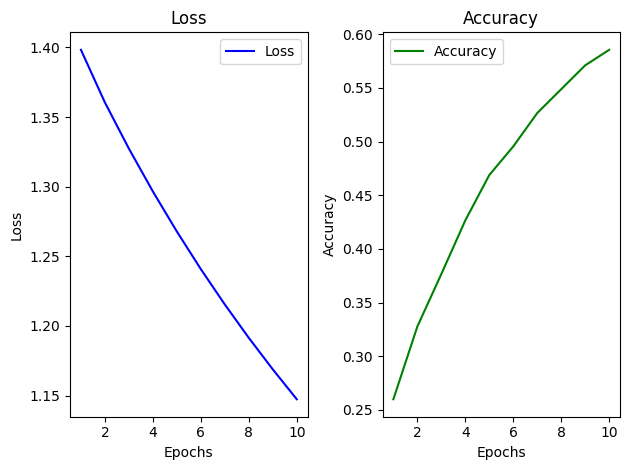

In [83]:
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = classifier_cnn_model(imgs.to(device))
        batch_predictions = torch.argmax(outputs, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [85]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.56      0.60      0.58        25
  EOSINOPHIL       0.40      0.40      0.40        25
    MONOCYTE       0.55      0.68      0.61        25
  LYMPHOCYTE       0.71      0.48      0.57        25

    accuracy                           0.54       100
   macro avg       0.55      0.54      0.54       100
weighted avg       0.55      0.54      0.54       100

